In [2]:
# Import necessary libraries
import os
import gc
import torch
import pandas as pd
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils
from transformers import AutoTokenizer, AutoModelForCausalLM

# Parameters
dataset_name = 'manjuvallayil/factver_master'
model_name = 'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'
llama_model_name = 'meta-llama/Llama-2-7b-chat-hf'

selected_claim_id = 'Claim_10'
similarity_threshold = 0.75  # delta for cosine similarity
alpha = 0.5  # parameter for weighted vector combination of thematic embedding
n_docs = 6  # number of docs to retrieve by RAG
n_components_carag = 3  # number of clusters for CARAG
n_components_carag_u = 10  # number of clusters for CARAG-U

# Paths for RAGUtils
passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

# Initialize LLaMA model
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_name)
llama_model = AutoModelForCausalLM.from_pretrained(llama_model_name)

# Initialize utilities
data_utils = DataUtils(dataset_name)
model_utils = ModelUtils(model_name, embedding_model_name)
lime_utils = LIMEUtils(model_utils)
soi_utils = SOIUtils(model_utils)
rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)

# Function to generate LLM-based explanation
def generate_llm_summary(claim, evidences):
    # Clear the GPU cache first
    gc.collect()
    torch.cuda.empty_cache()
    combined_evidence = ' '.join([evidence for evidence in evidences])
    prompt = f"Claim: {claim}\nEvidence: {combined_evidence}\nYou are a fact verification assistant. From the given Claim and its Evidence, determine if the claim is supported by the evidence and generate a concise explanation (two sentences max)."
    
    with torch.no_grad():
        inputs = llama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
        outputs = llama_model.generate(inputs['input_ids'], max_new_tokens=200)
    
    return llama_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()


"""
## For CARAG ##
# Load themed data
theme, themed_data = data_utils.filter_by_theme(selected_claim_id)

# CARAG: Themed data clustering
if not themed_data.empty:
    # Get embeddings for themed data
    all_texts = [row['Claim_text'] for _, row in themed_data.iterrows()]
    for _, row in themed_data.iterrows():
        all_texts.extend(row['Evidence_text'])
    
    embeddings = model_utils.get_sent_embeddings(all_texts)
    
    # Apply GMM-EM clustering to themed data
    labels_carag = model_utils.cluster_embeddings(embeddings, n_components=n_components_carag)
    unique_labels_carag = set(labels_carag)
    print(f"Unique clusters identified within the theme {theme}: {unique_labels_carag}")

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id_carag = None
    claim_text = None

    for index, row in themed_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id_carag = labels_carag[index]
            claim_text = row['Claim_text']
            break

    if selected_cluster_id_carag is not None:
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id_carag}")

        # 1. RAG-based retrieval and explanation (AS BASELINE)
        rag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding=None, alpha=1.0)
        rag_explanation = generate_llm_summary(claim_text, rag_evidence)
        print("\nRAG Explanation:\n", rag_explanation)
        
        # 2. CARAG-based retrieval and explanation
        carag_soi = soi_utils.compute_soi(selected_claim_id, themed_data, labels_carag, selected_cluster_id_carag, similarity_threshold)
        carag_soi_evidences = carag_soi['related_claims'] + carag_soi['annotated_evidences'] + carag_soi['thematic_cluster_evidences']

        # Compute aggregated embedding for CARAG SOI
        carag_aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in carag_soi_evidences])
        
        # Retrieve evidence using CARAG's SOI-based embedding
        carag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, carag_aggregated_embedding, alpha=0.5)
        carag_explanation = generate_llm_summary(claim_text, carag_evidence)
        print("\nCARAG Explanation:\n", carag_explanation)
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster in CARAG.")

else:
    print(f"No data found for the theme of claim {selected_claim_id}.")
"""


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using the latest cached version of the dataset since manjuvallayil/factver_master couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/qsh5523/.cache/huggingface/datasets/manjuvallayil___factver_master/default/0.0.0/50f3bf76490fd2c7dfa76bb772ddabe2857e4eae (last modified on Fri Dec 20 19:40:27 2024).
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda
INFO:root:Classification model loaded on CUDA
/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning:

Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may

'\n## For CARAG ##\n# Load themed data\ntheme, themed_data = data_utils.filter_by_theme(selected_claim_id)\n\n# CARAG: Themed data clustering\nif not themed_data.empty:\n    # Get embeddings for themed data\n    all_texts = [row[\'Claim_text\'] for _, row in themed_data.iterrows()]\n    for _, row in themed_data.iterrows():\n        all_texts.extend(row[\'Evidence_text\'])\n    \n    embeddings = model_utils.get_sent_embeddings(all_texts)\n    \n    # Apply GMM-EM clustering to themed data\n    labels_carag = model_utils.cluster_embeddings(embeddings, n_components=n_components_carag)\n    unique_labels_carag = set(labels_carag)\n    print(f"Unique clusters identified within the theme {theme}: {unique_labels_carag}")\n\n    # Ensure the selected claim is in the identified cluster\n    selected_cluster_id_carag = None\n    claim_text = None\n\n    for index, row in themed_data.iterrows():\n        unique_id = row[\'Claim_topic_id\'].split(\'_\')[-1]\n        if f"Claim_{unique_id}" == se

In [210]:
## For CARAG_U ##
selected_claim_id = 'Claim_44'
similarity_threshold = 0.75  # delta for cosine similarity
alpha = 0.25  # parameter for weighted vector combination of thematic embedding

# CARAG-U: Dataset-wide clustering
grouped_data = data_utils.get_full_data(selected_claim_id)

if not grouped_data.empty:
    # Get embeddings for dataset-wide clustering
    all_texts = [row['Claim_text'] for _, row in grouped_data.iterrows()]
    for _, row in grouped_data.iterrows():
        all_texts.extend(row['Evidence_text'])
    
    embeddings = model_utils.get_sent_embeddings(all_texts)
    
    # Apply GMM-EM clustering to the full dataset
    labels_carag_u = model_utils.cluster_embeddings(embeddings, n_components=n_components_carag_u)
    unique_labels_carag_u = set(labels_carag_u)
    print(f"Unique clusters identified in the dataset: {unique_labels_carag_u}")

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id_carag_u = None
    claim_text = None

    for index, row in grouped_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id_carag_u = labels_carag_u[index]
            claim_text = row['Claim_text']
            break

    if selected_cluster_id_carag_u is not None:
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id_carag_u}")

        # 3. CARAG-U-based retrieval and explanation
        carag_u_soi = soi_utils.compute_soi_carag_u(selected_claim_id, grouped_data, labels_carag_u, selected_cluster_id_carag_u, similarity_threshold)
        carag_u_soi_evidences = carag_u_soi['refined_cluster_evidences']

        # Compute aggregated embedding for CARAG-U SOI
        carag_u_aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in carag_u_soi_evidences])
        
        # Retrieve evidence using CARAG-U's dataset-wide embedding
        carag_u_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, carag_u_aggregated_embedding, alpha)
        carag_u_explanation = generate_llm_summary(claim_text, carag_u_evidence)
        print("\nCARAG_U Explanation:\n", carag_u_explanation)
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster in CARAG-U.")

else:
    print("No data found in the dataset.")

Claim ID Claim_44 is valid and exists in the dataset.


Batches:   0%|          | 0/116 [00:00<?, ?it/s]

Unique clusters identified in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
The selected claim (Claim_44) belongs to cluster 8


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


CARAG_U Explanation:
 Claim: Climate change is caused by atomspheric concentration of greenhouse gasses
Evidence: There are a number of industrial decarbonisation schemes, including energy efficiency and emissions trading schemes, that we administer for the UK and regulate in England. At the heart of all these schemes is the goal of reducing greenhouse gas emissions with a particular focus on carbon emissions. This greenhouse gas trading scheme forms part of the UK government's ambition to achieve net zero emissions by 2050.Global business is increasingly familiar with the prospect of short-notice public investigatory attention, whether from regulators, law enforcement, political forces or as a consequence of sanctions, and this can  in in some cases  devastate individual and corporate reputation. The system, made up of a primary market of allowances and a secondary market mainly of derivatives based on allowances, is a core element in Europe's plan to cut its emissions. The UK's carb

In [195]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import art3d

# Load dataset and global vectors
dataset_vectors = rag_utils.load_dataset_vectors()
print(f"Loaded {len(dataset_vectors)} vectors from the FAISS index.")

# Load the data from the CSV file
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Extract themes
themes = df['Theme'].unique() if 'Theme' in df.columns else []
print(f"Available themes in results.csv: {themes}")

# Extract claim IDs and explanations
claim_ids = df['Claim_id'].tolist()
annotated_explanations = df['Annotated'].tolist()
rag_explanations = df['RAG'].tolist()
carag_explanations = df['CARAG'].tolist()
carag_u_explanations = df['CARAG_U'].tolist()

# Generate embeddings
def generate_explanation_embeddings(explanations, model_utils):
    explanation_embeddings = model_utils.get_sent_embeddings(explanations)
    return np.atleast_2d(explanation_embeddings)

annotated_embeddings = generate_explanation_embeddings(annotated_explanations, model_utils)
rag_embeddings = generate_explanation_embeddings(rag_explanations, model_utils)
carag_embeddings = generate_explanation_embeddings(carag_explanations, model_utils)
carag_u_embeddings = generate_explanation_embeddings(carag_u_explanations, model_utils)

# Generate themed data embeddings
themed_data_embeddings = {}
for theme in themes:
    themed_data = data_utils.themed_data(theme)
    if not themed_data.empty:
        valid_evidence_texts = themed_data['Evidence_text'].dropna().tolist()
        valid_evidence_texts_flat = [item for sublist in valid_evidence_texts for item in sublist if isinstance(item, str) and item.strip()]
        if valid_evidence_texts_flat:
            themed_vectors = model_utils.get_sent_embeddings(valid_evidence_texts_flat)
            themed_data_embeddings[theme] = themed_vectors
            print(f"Generated embeddings for theme '{theme}' with {len(themed_vectors)} vectors.")
        else:
            print(f"No valid evidence texts found for theme '{theme}'.")

# Plot helper functions
def plot_2d_convex_hull(ax, points, color, alpha=0.3):
    if len(points) >= 3:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            x = points[simplex, 0]
            y = points[simplex, 1]
            ax.fill(x, y, color=color, alpha=alpha)

def plot_3d_convex_hull(ax, points, color, alpha=0.3):
    if len(points) >= 4:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            triangle = [[points[simplex[0]], points[simplex[1]], points[simplex[2]]]]
            poly = art3d.Poly3DCollection(triangle, alpha=alpha, facecolor=color, edgecolor='gray', linewidths=0.5)
            ax.add_collection3d(poly)
########################

"""
def apply_tsne(embeddings, n_components=2):
    tsne = TSNE(n_components=n_components, perplexity=30, random_state=42)
    return tsne.fit_transform(embeddings)
"""

# Function to apply t-SNE
def apply_tsne(embeddings):
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ensure perplexity is less than n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    return tsne.fit_transform(embeddings)

# Apply PCA and t-SNE transformations to RAG, CARAG, CARAG_U, and themed embeddings
all_embeddings = np.vstack([rag_embeddings, carag_embeddings, carag_u_embeddings, *themed_data_embeddings.values()])
labels = (
    ['RAG'] * len(rag_embeddings)
    + ['CARAG'] * len(carag_embeddings)
    + ['CARAG_U'] * len(carag_u_embeddings)
    + sum([[theme] * len(vectors) for theme, vectors in themed_data_embeddings.items()], [])
)

# PCA transformation
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_pca = pca_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_pca = {
    theme: pca_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation
tsne_embeddings = apply_tsne(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_tsne = tsne_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Visualization settings
theme_colors = {'Climate': 'blue', 'Covid': 'green', 'Electric_Vehicles': 'purple'}
scatter_colors = {'RAG': 'red', 'CARAG': 'teal', 'CARAG_U': 'cyan'}

# Theme and scatter selection ['Covid', 'Climate', 'Electric_Vehicles'] 
selected_themes = ['Covid', 'Climate', 'Electric_Vehicles']  # Contours for these themes
selected_scatter_themes = ['Electric_Vehicles']   # Scatter points for these themes



Loaded 3102 vectors from the FAISS index.
Available themes in results.csv: ['Climate' 'Covid' 'Electric_Vehicles' nan]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Generated embeddings for theme 'Climate' with 486 vectors.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Generated embeddings for theme 'Covid' with 2004 vectors.


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generated embeddings for theme 'Electric_Vehicles' with 606 vectors.


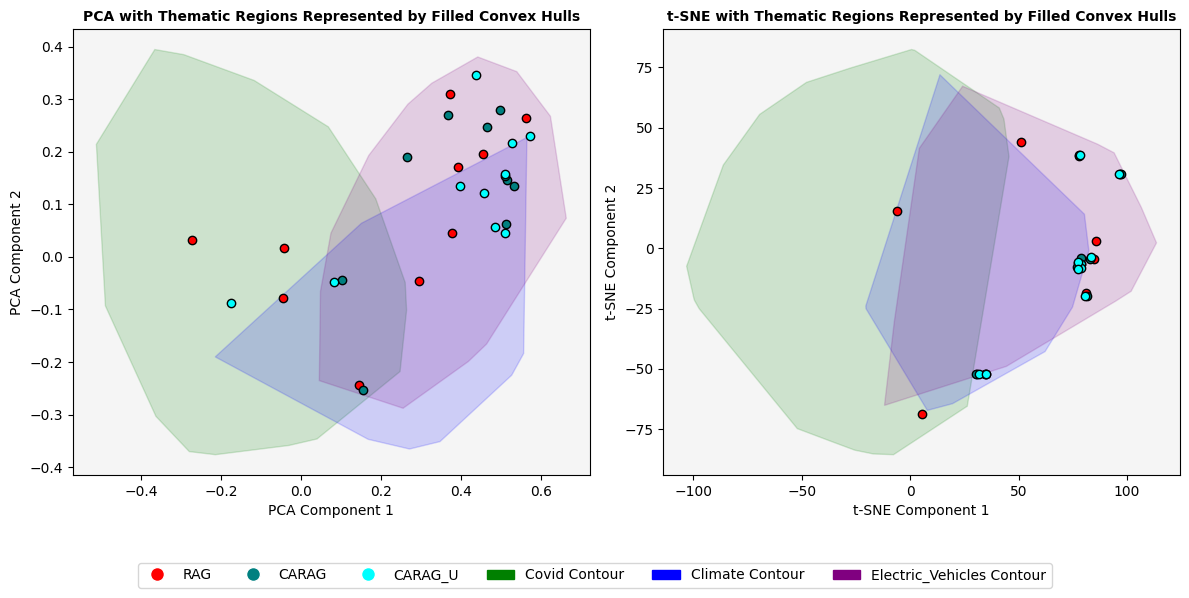

In [196]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Patch
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D

# Function to plot filled convex hulls
def plot_filled_convex_hull(ax, points, color, alpha=0.16):
    if len(points) >= 3:  # ConvexHull requires at least 3 points in 2D
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        polygon = Polygon(polygon_points, closed=True, facecolor=color, alpha=alpha, edgecolor=color)
        ax.add_patch(polygon)

# Filter scatter points by selected scatter themes
scatter_points_pca = {'RAG': [], 'CARAG': [], 'CARAG_U': []}
scatter_points_tsne = {'RAG': [], 'CARAG': [], 'CARAG_U': []}

for theme in selected_scatter_themes:
    if theme in df['Theme'].values:
        indices = df[df['Theme'] == theme].index
        scatter_points_pca['RAG'].extend(rag_pca[indices])
        scatter_points_pca['CARAG'].extend(carag_pca[indices])
        scatter_points_pca['CARAG_U'].extend(carag_u_pca[indices])
        scatter_points_tsne['RAG'].extend(rag_tsne[indices])
        scatter_points_tsne['CARAG'].extend(carag_tsne[indices])
        scatter_points_tsne['CARAG_U'].extend(carag_u_tsne[indices])

# Convert lists back to NumPy arrays
scatter_points_pca = {k: np.array(v) for k, v in scatter_points_pca.items()}
scatter_points_tsne = {k: np.array(v) for k, v in scatter_points_tsne.items()}

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# PCA with filled shapes
for theme in selected_themes:
    if theme in themed_pca:
        points = themed_pca[theme]
        plot_filled_convex_hull(axes[0], points, theme_colors[theme])
for label, points in scatter_points_pca.items():
    if len(points) > 0:
        axes[0].scatter(points[:, 0], points[:, 1], color=scatter_colors[label], label=label, edgecolor='black')
axes[0].set_title("PCA with Thematic Regions Represented by Filled Convex Hulls", fontsize=10, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_facecolor('#f5f5f5')

# t-SNE with filled shapes
for theme in selected_themes:
    if theme in themed_tsne:
        points = themed_tsne[theme]
        plot_filled_convex_hull(axes[1], points, theme_colors[theme])
for label, points in scatter_points_tsne.items():
    if len(points) > 0:
        axes[1].scatter(points[:, 0], points[:, 1], color=scatter_colors[label], label=label, edgecolor='black')
axes[1].set_title("t-SNE with Thematic Regions Represented by Filled Convex Hulls", fontsize=10, fontweight='bold')
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].set_facecolor('#f5f5f5')

# Scatter legends as points
scatter_legend_handles = [
    Line2D([], [], marker='o', color='white', markerfacecolor=scatter_colors[label], markersize=10, label=label)
    for label in scatter_colors
]

# Theme legends as patches
theme_patches = [
    Patch(color=theme_colors[theme], label=f"{theme} Contour")
    for theme in selected_themes if theme in theme_colors
]

# Combine scatter points and theme patches for the legend
combined_handles = scatter_legend_handles + theme_patches

# Add a single legend below both plots
fig.legend(
    handles=combined_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),  # Position the legend at the footer
    ncol=len(combined_handles),  # Arrange all items in a single row
    frameon=True
)

# Adjust the plot layout to make space for the footer legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin for the legend
plt.show()

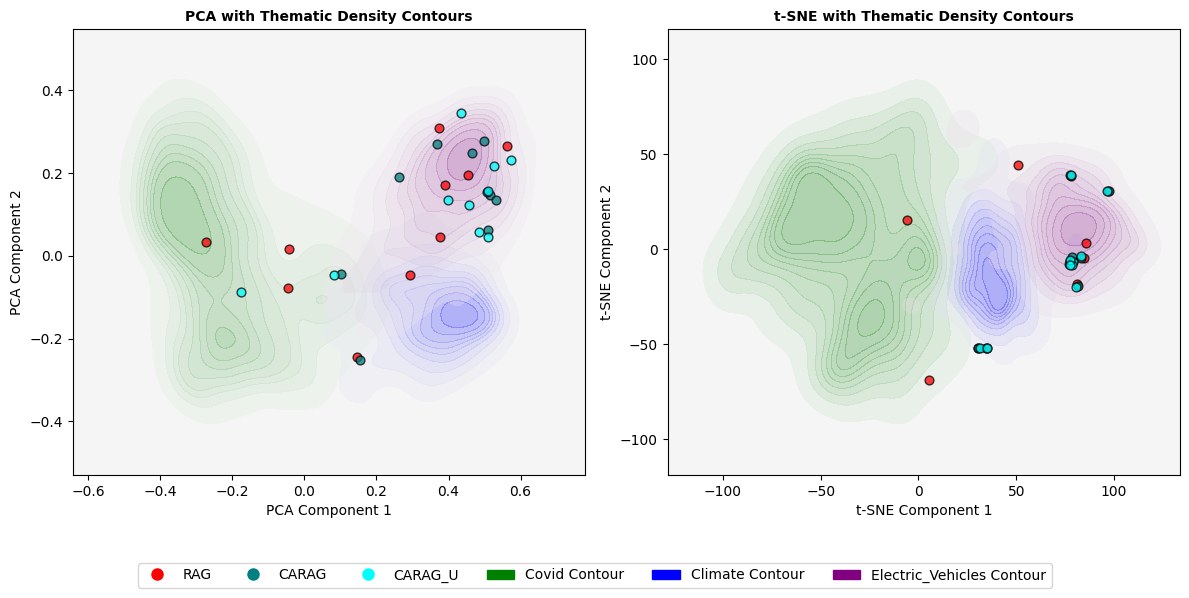

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# PCA plot with separate thematic densities
for theme in selected_themes:
    if theme in themed_pca and themed_pca[theme].shape[0] > 1:  # Ensure there are enough points for KDE
        sns.kdeplot(
            x=themed_pca[theme][:, 0],
            y=themed_pca[theme][:, 1],
            ax=axes[0],
            fill=True,
            cmap=sns.light_palette(theme_colors[theme], as_cmap=True),
            alpha=0.3,
            label=f'{theme} Contour'
        )
for label, points in scatter_points_pca.items():
    if len(points) > 0:
        axes[0].scatter(points[:, 0], points[:, 1], color=scatter_colors[label], edgecolor='black', label=label, s=40, alpha=0.75)
axes[0].set_title("PCA with Thematic Density Contours", fontsize=10, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_facecolor('#f5f5f5')

# t-SNE plot with separate thematic densities
for theme in selected_themes:
    if theme in themed_tsne and themed_tsne[theme].shape[0] > 1:  # Ensure there are enough points for KDE
        sns.kdeplot(
            x=themed_tsne[theme][:, 0],
            y=themed_tsne[theme][:, 1],
            ax=axes[1],
            fill=True,
            cmap=sns.light_palette(theme_colors[theme], as_cmap=True),
            alpha=0.3,
            label=f'{theme} Contour'
        )
for label, points in scatter_points_tsne.items():
    if len(points) > 0:
        axes[1].scatter(points[:, 0], points[:, 1], color=scatter_colors[label], edgecolor='black', label=label, s=40, alpha=0.75)
axes[1].set_title("t-SNE with Thematic Density Contours", fontsize=10, fontweight='bold')
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].set_facecolor('#f5f5f5')

# Theme legends as patches
theme_patches = [Patch(color=theme_colors[theme], label=f"{theme} Contour") for theme in selected_themes if theme in theme_colors]

# Scatter legends as points
scatter_legend_handles = [
    plt.Line2D([], [], marker='o', color='white', markerfacecolor=scatter_colors[label], markersize=10, label=label)
    for label in scatter_colors
]

# Combine scatter points and theme patches for the legend
combined_handles = scatter_legend_handles + theme_patches

# Add a single legend below both plots
fig.legend(
    handles=combined_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),  # Position the legend at the footer
    ncol=len(combined_handles),  # Arrange all items in a single row
    frameon=True
)

# Adjust the plot layout to make space for the footer legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin for the legend
plt.show()

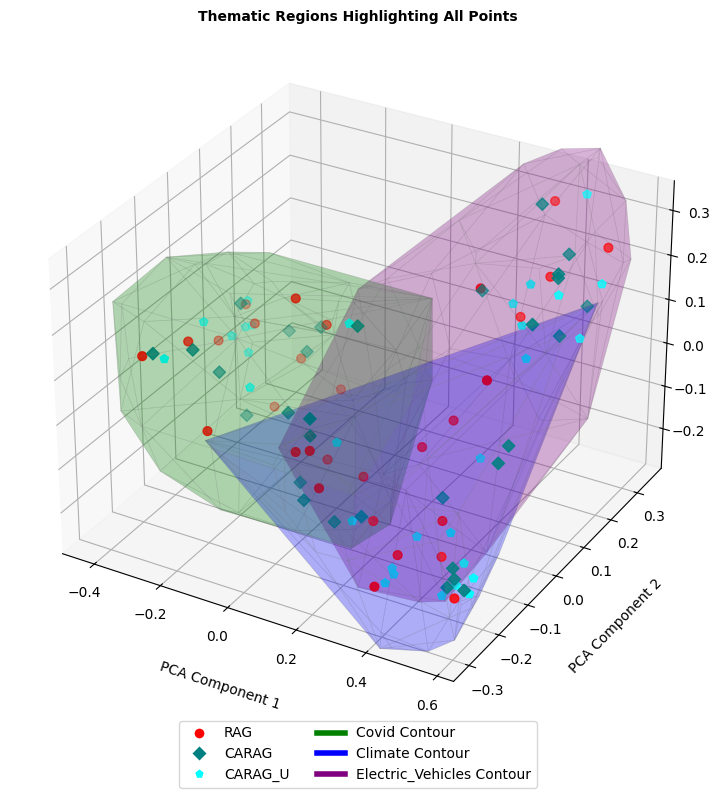

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA

# Function to plot convex hulls using Poly3DCollection
def plot_convex_hull_faces(ax, points, color, alpha=0.16):  # Supports transparency
    if len(points) >= 4:  # ConvexHull requires at least 4 points in 3D
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            triangle = [[points[simplex[0]], points[simplex[1]], points[simplex[2]]]]
            poly = art3d.Poly3DCollection(triangle, alpha=alpha, facecolor=color, edgecolor='gray', linewidths=0.5)
            ax.add_collection3d(poly)

# PCA transformation (3D)
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_pca = pca_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_pca = {
    theme: pca_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# 3D Visualization for PCA
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter points for PCA
for label, points, marker in zip(['RAG', 'CARAG', 'CARAG_U'], [rag_pca, carag_pca, carag_u_pca], ['o', 'D', 'p']):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=scatter_colors[label], label=label, s=40, marker=marker)

# Plot thematic convex hulls
for theme in selected_themes:
    if theme in themed_pca:
        plot_convex_hull_faces(ax, themed_pca[theme], color=theme_colors[theme], alpha=0.16)

# Titles and labels
ax.set_title("Thematic Regions Highlighting All Points", fontsize=10, fontweight='bold')
ax.set_xlabel("PCA Component 1", labelpad=15)  # Add padding to X-axis
ax.set_ylabel("PCA Component 2", labelpad=15)  # Add padding to Y-axis
ax.set_zlabel("PCA Component 3", labelpad=15)  # Add padding to Z-axis
#ax.set_facecolor('#f5f5f5')
# Legend
scatter_legend = [
    plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor=scatter_colors[label], 
               markersize=8, label=label, linestyle='None') 
    for label, marker in zip(['RAG', 'CARAG', 'CARAG_U'], ['o', 'D', 'p'])
]

theme_legend = [
    plt.Line2D([0], [0], color=theme_colors[theme], lw=4, label=f'{theme} Contour') 
    for theme in selected_themes if theme in theme_colors
]

# Combine scatter points and theme patches for the legend
ax.legend(handles=scatter_legend + theme_legend, loc='lower center', 
          bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True)
plt.tight_layout()
plt.show()

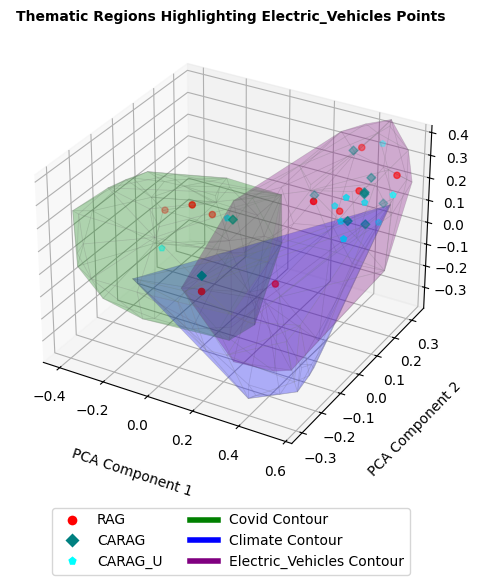

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA

# Function to plot convex hulls using Poly3DCollection
def plot_convex_hull_faces(ax, points, color, alpha=0.16):  # Supports transparency
    if len(points) >= 4:  # ConvexHull requires at least 4 points in 3D
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            triangle = [[points[simplex[0]], points[simplex[1]], points[simplex[2]]]]
            poly = art3d.Poly3DCollection(triangle, alpha=alpha, facecolor=color, edgecolor='gray', linewidths=0.5)
            ax.add_collection3d(poly)

# PCA transformation (3D)
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_pca = pca_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_pca = {
    theme: pca_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Filter scatter points for selected scatter themes
scatter_points = {'RAG': [], 'CARAG': [], 'CARAG_U': []}
for theme in selected_scatter_themes:
    if theme in df['Theme'].values:
        indices = df[df['Theme'] == theme].index
        scatter_points['RAG'].extend(rag_pca[indices])
        scatter_points['CARAG'].extend(carag_pca[indices])
        scatter_points['CARAG_U'].extend(carag_u_pca[indices])

# Convert lists back to NumPy arrays for scatter points
scatter_points = {label: np.array(points) for label, points in scatter_points.items() if len(points) > 0}

# Compute 90% scaling bounds
all_points = np.vstack([points for points in scatter_points.values() if len(points) > 0] + list(themed_pca.values()))
x_min, y_min, z_min = np.min(all_points, axis=0)
x_max, y_max, z_max = np.max(all_points, axis=0)

x_range, y_range, z_range = x_max - x_min, y_max - y_min, z_max - z_min
x_mid, y_mid, z_mid = (x_min + x_max) / 2, (y_min + y_max) / 2, (z_min + z_max) / 2

scale_factor = 0.9
x_min_scaled, x_max_scaled = x_mid - scale_factor * x_range / 2, x_mid + scale_factor * x_range / 2
y_min_scaled, y_max_scaled = y_mid - scale_factor * y_range / 2, y_mid + scale_factor * y_range / 2
z_min_scaled, z_max_scaled = z_mid - scale_factor * z_range / 2, z_mid + scale_factor * z_range / 2

# 3D Visualization for PCA
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot scatter points
for label, points, marker in zip(['RAG', 'CARAG', 'CARAG_U'], 
                                 [scatter_points.get('RAG', []), scatter_points.get('CARAG', []), scatter_points.get('CARAG_U', [])], 
                                 ['o', 'D', 'p']):
    if len(points) > 0:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=scatter_colors[label], label=label, s=20, marker=marker)

# Plot thematic convex hulls for selected themes
for theme in selected_themes:
    if theme in themed_pca and themed_pca[theme].shape[0] >= 4:  # Ensure enough points for ConvexHull
        plot_convex_hull_faces(ax, themed_pca[theme], color=theme_colors[theme], alpha=0.16)

# Titles and labels
ax.set_title("Thematic Regions Highlighting Electric_Vehicles Points", fontsize=10, fontweight='bold')
ax.set_xlabel("PCA Component 1", labelpad=15)  # Add padding to X-axis
ax.set_ylabel("PCA Component 2", labelpad=15)  # Add padding to Y-axis
ax.set_zlabel("PCA Component 3", labelpad=15)  # Add padding to Z-axis

# Apply scaling to axes
ax.set_xlim(x_min_scaled, x_max_scaled)
ax.set_ylim(y_min_scaled, y_max_scaled)
ax.set_zlim(z_min_scaled, z_max_scaled)

# Legend
scatter_legend = [
    plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor=scatter_colors[label], 
               markersize=8, label=label, linestyle='None') 
    for label, marker in zip(['RAG', 'CARAG', 'CARAG_U'], ['o', 'D', 'p'])
]

theme_legend = [
    plt.Line2D([0], [0], color=theme_colors[theme], lw=4, label=f'{theme} Contour') 
    for theme in selected_themes if theme in theme_colors
]

# Combine scatter points and theme patches for the legend
ax.legend(handles=scatter_legend + theme_legend, loc='lower center', 
          bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=True)
plt.tight_layout()
plt.show()

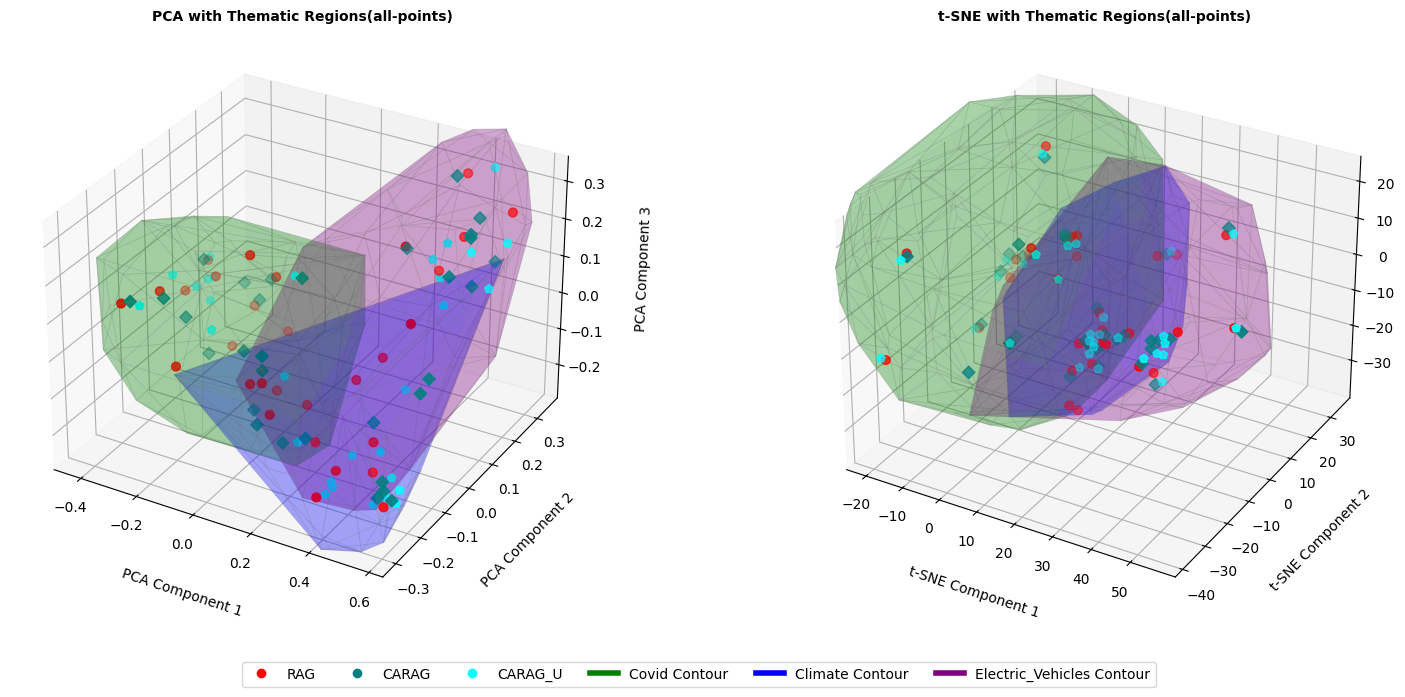

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to plot convex hulls using Poly3DCollection
def plot_convex_hull_faces(ax, points, color, alpha=0.19):  # Supports transparency
    if len(points) >= 4:  # ConvexHull requires at least 4 points in 3D
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            triangle = [[points[simplex[0]], points[simplex[1]], points[simplex[2]]]]
            poly = art3d.Poly3DCollection(triangle, alpha=alpha, facecolor=color, edgecolor='gray', linewidths=0.5)
            ax.add_collection3d(poly)

# PCA transformation (3D)
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_pca = pca_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_pca = {
    theme: pca_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation (3D)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_tsne = tsne_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# 3D Visualization for PCA and t-SNE
fig = plt.figure(figsize=(16, 8))

# PCA Plot
ax_pca = fig.add_subplot(121, projection='3d')
for label, points, marker in zip(['RAG', 'CARAG', 'CARAG_U'], [rag_pca, carag_pca, carag_u_pca], ['o', 'D', 'p']):
    ax_pca.scatter(points[:, 0], points[:, 1], points[:, 2], color=scatter_colors[label], label=label, s=40, marker=marker)

for theme in selected_themes:
    if theme in themed_pca:
        plot_convex_hull_faces(ax_pca, themed_pca[theme], color=theme_colors[theme], alpha=0.19)

ax_pca.set_title("PCA with Thematic Regions(all-points)", fontsize=10, fontweight='bold')
ax_pca.set_xlabel("PCA Component 1", labelpad=15)
ax_pca.set_ylabel("PCA Component 2", labelpad=15)
ax_pca.set_zlabel("PCA Component 3", labelpad=15)

# t-SNE Plot
ax_tsne = fig.add_subplot(122, projection='3d')
for label, points, marker in zip(['RAG', 'CARAG', 'CARAG_U'], [rag_tsne, carag_tsne, carag_u_tsne], ['o', 'D', 'p']):
    ax_tsne.scatter(points[:, 0], points[:, 1], points[:, 2], color=scatter_colors[label], label=label, s=40, marker=marker)

for theme in selected_themes:
    if theme in themed_tsne:
        plot_convex_hull_faces(ax_tsne, themed_tsne[theme], color=theme_colors[theme], alpha=0.19)

ax_tsne.set_title("t-SNE with Thematic Regions(all-points)", fontsize=10, fontweight='bold')
ax_tsne.set_xlabel("t-SNE Component 1", labelpad=15)
ax_tsne.set_ylabel("t-SNE Component 2", labelpad=15)
ax_tsne.set_zlabel("t-SNE Component 3", labelpad=15)

# Shared Legend
scatter_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_colors[label], markersize=8, label=label) for label in scatter_colors.keys()]
theme_legend = [plt.Line2D([0], [0], color=theme_colors[theme], lw=4, label=f'{theme} Contour') for theme in selected_themes if theme in theme_colors]

fig.legend(
    handles=scatter_legend + theme_legend,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.15),
    ncol=len(scatter_colors) + len(selected_themes),
    frameon=True
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust for the legend
plt.show()

In [211]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from IPython.display import display

# Load the data from results.csv
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Debugging: Print dimensions of the arrays
print(f"DataFrame rows: {len(df)}")
print(f"rag_pca size: {rag_pca.shape[0]}, carag_pca size: {carag_pca.shape[0]}, carag_u_pca size: {carag_u_pca.shape[0]}")

# Check for available themes and exclude `nan`
themes = [theme for theme in df['Theme'].unique() if pd.notna(theme)]
print(f"Available themes in results.csv (excluding nan): {themes}")

# Filter RAG, CARAG, and CARAG_U points by theme from the CSV file
rag_points = {}
carag_points = {}
carag_u_points = {}

for theme in themes:
    indices = df[df['Theme'] == theme].index
    valid_indices = indices[indices < rag_pca.shape[0]]  # Ensure indices are within bounds
    
    rag_points[theme] = rag_pca[np.array(valid_indices)]
    carag_points[theme] = carag_pca[np.array(valid_indices)]
    carag_u_points[theme] = carag_u_pca[np.array(valid_indices)]

    # Debugging: Print shapes of filtered data
    print(f"Theme '{theme}': {len(valid_indices)} points")

# Step 1: Calculate the centroids of each theme contour
theme_centroids_pca = {theme: np.mean(themed_pca[theme], axis=0) for theme in themes}
theme_centroids_tsne = {theme: np.mean(themed_tsne[theme], axis=0) for theme in themes}

# Step 2: Calculate distances of RAG points to theme centroids (PCA and t-SNE)
rag_distances_pca = {theme: cdist(rag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
rag_distances_tsne = {theme: cdist(rag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 3: Calculate distances of CARAG and CARAG_U points to theme centroids (PCA and t-SNE)
carag_distances_pca = {theme: cdist(carag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_distances_tsne = {theme: cdist(carag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}
carag_u_distances_pca = {theme: cdist(carag_u_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_u_distances_tsne = {theme: cdist(carag_u_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 4: Prepare DataFrames for RAG, CARAG, and CARAG_U distances with difference columns
theme_tables = {}
for theme in themes:
    theme_table = []
    for i in range(len(rag_distances_pca[theme])):
        theme_table.append({
            "Theme": theme,
            "Point Index": i,
            "RAG Distance (PCA)": rag_distances_pca[theme][i],
            "CARAG Distance (PCA)": carag_distances_pca[theme][i],
            "CARAG_U Distance (PCA)": carag_u_distances_pca[theme][i],
            "Difference (PCA - CARAG)": carag_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "Difference (PCA - CARAG_U)": carag_u_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "RAG Distance (t-SNE)": rag_distances_tsne[theme][i],
            "CARAG Distance (t-SNE)": carag_distances_tsne[theme][i],
            "CARAG_U Distance (t-SNE)": carag_u_distances_tsne[theme][i],
            "Difference (t-SNE - CARAG)": carag_distances_tsne[theme][i] - rag_distances_tsne[theme][i],
            "Difference (t-SNE - CARAG_U)": carag_u_distances_tsne[theme][i] - rag_distances_tsne[theme][i]
        })
    
    # Convert to DataFrame
    table_df = pd.DataFrame(theme_table)
    
    # Calculate averages for each numeric column
    averages = table_df.mean(numeric_only=True).to_dict()
    averages["Theme"] = f"{theme} - Average"
    averages["Point Index"] = "N/A"
    
    # Append averages as the last row using pd.concat
    average_row_df = pd.DataFrame([averages])
    table_df = pd.concat([table_df, average_row_df], ignore_index=True)
    
    theme_tables[theme] = table_df

# Display theme-specific tables with average rows
for theme, table in theme_tables.items():
    print(f"\nEuclidean Distance Table for Theme: {theme}")
    display(table)

# Step 5: Prepare a combined alignment comparison table
alignment_comparison = []
for theme in themes:
    rag_avg_distance_pca = np.mean(rag_distances_pca[theme])
    carag_avg_distance_pca = np.mean(carag_distances_pca[theme])
    carag_u_avg_distance_pca = np.mean(carag_u_distances_pca[theme])
    rag_avg_distance_tsne = np.mean(rag_distances_tsne[theme])
    carag_avg_distance_tsne = np.mean(carag_distances_tsne[theme])
    carag_u_avg_distance_tsne = np.mean(carag_u_distances_tsne[theme])

    alignment_comparison.append({
        "Theme": theme,
        "RAG Avg Distance (PCA)": rag_avg_distance_pca,
        "CARAG Avg Distance (PCA)": carag_avg_distance_pca,
        "CARAG_U Avg Distance (PCA)": carag_u_avg_distance_pca,
        "Difference (PCA - CARAG)": carag_avg_distance_pca - rag_avg_distance_pca,
        "Difference (PCA - CARAG_U)": carag_u_avg_distance_pca - rag_avg_distance_pca,
        "RAG Avg Distance (t-SNE)": rag_avg_distance_tsne,
        "CARAG Avg Distance (t-SNE)": carag_avg_distance_tsne,
        "CARAG_U Avg Distance (t-SNE)": carag_u_avg_distance_tsne,
        "Difference (t-SNE - CARAG)": carag_avg_distance_tsne - rag_avg_distance_tsne,
        "Difference (t-SNE - CARAG_U)": carag_u_avg_distance_tsne - rag_avg_distance_tsne,
        "Better Alignment (PCA)": "CARAG_U" if carag_u_avg_distance_pca < min(carag_avg_distance_pca, rag_avg_distance_pca) else 
                                   ("CARAG" if carag_avg_distance_pca < rag_avg_distance_pca else "RAG"),
        "Better Alignment (t-SNE)": "CARAG_U" if carag_u_avg_distance_tsne < min(carag_avg_distance_tsne, rag_avg_distance_tsne) else 
                                     ("CARAG" if carag_avg_distance_tsne < rag_avg_distance_tsne else "RAG")
    })

# Convert alignment comparison to a DataFrame
alignment_df = pd.DataFrame(alignment_comparison)

# Add an average row for the combined table using pd.concat
average_row = alignment_df.mean(numeric_only=True).to_dict()
average_row["Theme"] = "Overall Average"
average_row_df = pd.DataFrame([average_row])
alignment_df = pd.concat([alignment_df, average_row_df], ignore_index=True)
alignment_df.to_csv("carag_u_euclidean_alignment_comparison.csv", index=False)
# Display the combined alignment comparison table with average row
print("\nCombined Alignment Comparison Table:")
display(alignment_df)

DataFrame rows: 31
rag_pca size: 31, carag_pca size: 31, carag_u_pca size: 31
Available themes in results.csv (excluding nan): ['Climate', 'Covid', 'Electric_Vehicles']
Theme 'Climate': 10 points
Theme 'Covid': 10 points
Theme 'Electric_Vehicles': 10 points

Euclidean Distance Table for Theme: Climate


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),CARAG_U Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Distance (t-SNE),CARAG Distance (t-SNE),CARAG_U Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U)
0,Climate,0,0.064223,0.687872,0.162615,0.623649,0.098391,14.953634,15.638864,15.070145,0.685230,0.116510
1,Climate,1,0.265104,0.129733,0.150190,-0.135371,-0.114914,15.149913,14.825737,14.804955,-0.324176,-0.344957
2,Climate,2,0.070344,0.153207,0.161293,0.082864,0.090949,14.906134,14.808432,14.798561,-0.097702,-0.107574
3,Climate,3,0.156707,0.248352,0.156249,0.091645,-0.000458,14.930939,15.190733,14.810185,0.259793,-0.120755
4,Climate,4,0.171203,0.147523,0.182439,-0.023681,0.011236,14.788578,14.808535,14.771124,0.019957,-0.017455
5,Climate,5,0.134938,0.095840,0.082995,-0.039097,-0.051943,15.086378,14.970482,14.942154,-0.115897,-0.144224
6,Climate,6,0.351130,0.195715,0.207596,-0.155416,-0.143534,15.226084,14.763332,14.749947,-0.462751,-0.476137
7,Climate,7,0.348838,0.274766,0.119089,-0.074072,-0.229750,15.297335,14.838866,14.932914,-0.458469,-0.364421
8,Climate,8,0.553653,0.145127,0.287539,-0.408525,-0.266113,15.472376,15.065263,15.211217,-0.407113,-0.261158
9,Climate,9,0.388361,0.255672,0.174177,-0.132689,-0.214184,14.900176,14.828794,14.832665,-0.071382,-0.067511



Euclidean Distance Table for Theme: Covid


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),CARAG_U Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Distance (t-SNE),CARAG Distance (t-SNE),CARAG_U Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U)
0,Covid,0,0.121760,0.230235,0.240850,0.108475,0.119090,12.782836,12.746672,12.579236,-0.036165,-0.203600
1,Covid,1,0.141362,0.263027,0.294068,0.121664,0.152706,12.610769,12.654856,12.561708,0.044087,-0.049061
2,Covid,2,0.344181,0.310468,0.305085,-0.033714,-0.039096,12.656172,12.657378,12.692625,0.001205,0.036453
3,Covid,3,0.192250,0.200771,0.219006,0.008521,0.026756,12.601719,12.588941,12.587033,-0.012778,-0.014686
4,Covid,4,0.152887,0.233124,0.170022,0.080238,0.017136,12.756818,12.667093,12.636542,-0.089725,-0.120276
5,Covid,5,0.219423,0.208713,0.165850,-0.010710,-0.053574,12.674688,12.690766,12.596327,0.016079,-0.078361
6,Covid,6,0.211912,0.189596,0.160121,-0.022316,-0.051790,12.890914,12.750859,12.608623,-0.140055,-0.282290
7,Covid,7,0.661344,0.177071,0.612302,-0.484273,-0.049042,13.393892,12.905114,13.333811,-0.488778,-0.060081
8,Covid,8,0.397602,0.277035,0.617529,-0.120567,0.219928,13.128579,12.958667,13.313071,-0.169912,0.184492
9,Covid,9,0.555749,0.357855,0.625332,-0.197894,0.069583,13.304174,13.040243,13.375382,-0.263931,0.071208



Euclidean Distance Table for Theme: Electric_Vehicles


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),CARAG_U Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Distance (t-SNE),CARAG Distance (t-SNE),CARAG_U Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U)
0,Electric_Vehicles,0,0.239937,0.174051,0.135239,-0.065887,-0.104698,33.990212,34.046917,34.051238,0.056705,0.061026
1,Electric_Vehicles,1,0.684255,0.137810,0.142496,-0.546444,-0.541758,34.839325,34.292177,34.082119,-0.547148,-0.757206
2,Electric_Vehicles,2,0.502683,0.159553,0.125545,-0.343130,-0.377138,34.623402,34.052350,34.106753,-0.571052,-0.516649
3,Electric_Vehicles,3,0.162986,0.137526,0.207510,-0.025460,0.044524,34.191764,34.029637,33.981199,-0.162127,-0.210565
4,Electric_Vehicles,4,0.481119,0.471118,0.634682,-0.010001,0.153563,34.445832,34.438326,34.752330,-0.007506,0.306498
5,Electric_Vehicles,5,0.022696,0.165705,0.156731,0.143009,0.134035,34.166634,34.051712,34.027469,-0.114922,-0.139164
6,Electric_Vehicles,6,0.233363,0.219808,0.267055,-0.013554,0.033692,34.176458,34.185079,34.110578,0.008621,-0.065880
7,Electric_Vehicles,7,0.294806,0.158754,0.156445,-0.136052,-0.138362,34.280679,34.056578,34.058621,-0.224102,-0.222058
8,Electric_Vehicles,8,0.458530,0.351989,0.371536,-0.106541,-0.086994,34.611156,34.471789,34.492642,-0.139368,-0.118514
9,Electric_Vehicles,9,0.109248,0.158233,0.046132,0.048984,-0.063116,34.103038,34.088177,34.163020,-0.014861,0.059982



Combined Alignment Comparison Table:


,Theme,RAG Avg Distance (PCA),CARAG Avg Distance (PCA),CARAG_U Avg Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Avg Distance (t-SNE),CARAG Avg Distance (t-SNE),CARAG_U Avg Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U),Better Alignment (PCA),Better Alignment (t-SNE)
0,Climate,0.250450,0.233381,0.168418,-0.017069,-0.082032,15.071155,14.973904,14.892387,-0.097251,-0.178768,CARAG_U,CARAG_U
1,Covid,0.299847,0.244790,0.341017,-0.055058,0.041170,12.880056,12.766059,12.828436,-0.113997,-0.051620,CARAG,CARAG
2,Electric_Vehicles,0.318962,0.213455,0.224337,-0.105508,-0.094625,34.342850,34.171274,34.182597,-0.171576,-0.160253,CARAG,CARAG
3,Overall Average,0.289753,0.230542,0.244591,-0.059211,-0.045163,20.764687,20.637079,20.634473,-0.127608,-0.130214,NaN,NaN


In [222]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from IPython.display import display

# Load the data from results.csv
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Debugging: Print dimensions of the arrays
print(f"DataFrame rows: {len(df)}")
print(f"rag_pca size: {rag_pca.shape[0]}, carag_pca size: {carag_pca.shape[0]}, carag_u_pca size: {carag_u_pca.shape[0]}")

# Check for available themes and exclude `nan`
themes = [theme for theme in df['Theme'].unique() if pd.notna(theme)]
print(f"Available themes in results.csv (excluding nan): {themes}")

# Filter RAG, CARAG, and CARAG_U points by theme from the CSV file
rag_points = {}
carag_points = {}
carag_u_points = {}

for theme in themes:
    indices = df[df['Theme'] == theme].index
    valid_indices = indices[indices < rag_pca.shape[0]]  # Ensure indices are within bounds
    
    rag_points[theme] = rag_pca[np.array(valid_indices)]
    carag_points[theme] = carag_pca[np.array(valid_indices)]
    carag_u_points[theme] = carag_u_pca[np.array(valid_indices)]

    # Debugging: Print shapes of filtered data
    print(f"Theme '{theme}': {len(valid_indices)} points")

# Step 1: Calculate the centroids of each theme contour
theme_centroids_pca = {theme: np.mean(themed_pca[theme], axis=0) for theme in themes}
theme_centroids_tsne = {theme: np.mean(themed_tsne[theme], axis=0) for theme in themes}

# Step 2: Calculate distances of RAG points to theme centroids (PCA and t-SNE)
rag_distances_pca = {theme: cdist(rag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
rag_distances_tsne = {theme: cdist(rag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 3: Calculate distances of CARAG and CARAG_U points to theme centroids (PCA and t-SNE)
carag_distances_pca = {theme: cdist(carag_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_distances_tsne = {theme: cdist(carag_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}
carag_u_distances_pca = {theme: cdist(carag_u_points[theme], [theme_centroids_pca[theme]]).flatten() for theme in themes}
carag_u_distances_tsne = {theme: cdist(carag_u_points[theme], [theme_centroids_tsne[theme]]).flatten() for theme in themes}

# Step 4: Prepare DataFrames for RAG, CARAG, and CARAG_U distances with difference columns
theme_tables = {}
for theme in themes:
    theme_table = []
    for i in range(len(rag_distances_pca[theme])):
        theme_table.append({
            "Theme": theme,
            "Point Index": i,
            "RAG Distance (PCA)": rag_distances_pca[theme][i],
            "CARAG Distance (PCA)": carag_distances_pca[theme][i],
            "CARAG_U Distance (PCA)": carag_u_distances_pca[theme][i],
            "Difference (PCA - CARAG)": carag_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "Difference (PCA - CARAG_U)": carag_u_distances_pca[theme][i] - rag_distances_pca[theme][i],
            "RAG Distance (t-SNE)": rag_distances_tsne[theme][i],
            "CARAG Distance (t-SNE)": carag_distances_tsne[theme][i],
            "CARAG_U Distance (t-SNE)": carag_u_distances_tsne[theme][i],
            "Difference (t-SNE - CARAG)": carag_distances_tsne[theme][i] - rag_distances_tsne[theme][i],
            "Difference (t-SNE - CARAG_U)": carag_u_distances_tsne[theme][i] - rag_distances_tsne[theme][i]
        })
    
    # Convert to DataFrame
    table_df = pd.DataFrame(theme_table)
    
    # Calculate averages for each numeric column
    averages = table_df.mean(numeric_only=True).to_dict()
    averages["Theme"] = f"{theme} - Average"
    averages["Point Index"] = "N/A"
    
    # Append averages as the last row using pd.concat
    average_row_df = pd.DataFrame([averages])
    table_df = pd.concat([table_df, average_row_df], ignore_index=True)
    
    theme_tables[theme] = table_df


# Combine all theme-specific tables into a single DataFrame
combined_theme_table = pd.DataFrame()

for theme, table in theme_tables.items():
    table['Theme'] = theme  # Add a Theme column to identify each theme
    # Update the "Theme" column for the average row where "Point Index" is "N/A"
    table.loc[table["Point Index"] == "N/A", "Theme"] = f"Avg Distance"
    combined_theme_table = pd.concat([combined_theme_table, table], ignore_index=True)

# Display the combined theme-specific table
print("Combined Euclidean Distance Table(all themes):")
display(combined_theme_table)

# Save the combined theme-specific table to a CSV file
theme_output_path = "carag_u_euclidean_distance_all_theme_distances.csv"
combined_theme_table.to_csv(theme_output_path, index=False)
print(f"Combined theme-specific table has been saved to '{theme_output_path}'.")

# Step 5: Prepare a combined alignment comparison table
alignment_comparison = []
for theme in themes:
    rag_avg_distance_pca = np.mean(rag_distances_pca[theme])
    carag_avg_distance_pca = np.mean(carag_distances_pca[theme])
    carag_u_avg_distance_pca = np.mean(carag_u_distances_pca[theme])
    rag_avg_distance_tsne = np.mean(rag_distances_tsne[theme])
    carag_avg_distance_tsne = np.mean(carag_distances_tsne[theme])
    carag_u_avg_distance_tsne = np.mean(carag_u_distances_tsne[theme])

    alignment_comparison.append({
        "Theme": theme,
        "RAG Avg Distance (PCA)": rag_avg_distance_pca,
        "CARAG Avg Distance (PCA)": carag_avg_distance_pca,
        "CARAG_U Avg Distance (PCA)": carag_u_avg_distance_pca,
        "Difference (PCA - CARAG)": carag_avg_distance_pca - rag_avg_distance_pca,
        "Difference (PCA - CARAG_U)": carag_u_avg_distance_pca - rag_avg_distance_pca,
        "RAG Avg Distance (t-SNE)": rag_avg_distance_tsne,
        "CARAG Avg Distance (t-SNE)": carag_avg_distance_tsne,
        "CARAG_U Avg Distance (t-SNE)": carag_u_avg_distance_tsne,
        "Difference (t-SNE - CARAG)": carag_avg_distance_tsne - rag_avg_distance_tsne,
        "Difference (t-SNE - CARAG_U)": carag_u_avg_distance_tsne - rag_avg_distance_tsne,
        "Better Alignment (PCA)": "CARAG_U" if carag_u_avg_distance_pca < min(carag_avg_distance_pca, rag_avg_distance_pca) else 
                                   ("CARAG" if carag_avg_distance_pca < rag_avg_distance_pca else "RAG"),
        "Better Alignment (t-SNE)": "CARAG_U" if carag_u_avg_distance_tsne < min(carag_avg_distance_tsne, rag_avg_distance_tsne) else 
                                     ("CARAG" if carag_avg_distance_tsne < rag_avg_distance_tsne else "RAG")
    })

# Convert alignment comparison to a DataFrame
alignment_df = pd.DataFrame(alignment_comparison)

# Add an average row for the combined table using pd.concat
average_row = alignment_df.mean(numeric_only=True).to_dict()
average_row["Theme"] = "Overall Average"
average_row_df = pd.DataFrame([average_row])
alignment_df = pd.concat([alignment_df, average_row_df], ignore_index=True)

# Save the combined alignment comparison table to a CSV file
alignment_output_path = "carag_u_euclidean_alignment_comparison.csv"
alignment_df.to_csv(alignment_output_path, index=False)

# Display the combined alignment comparison table with average row
print("\nCombined Alignment Comparison Table:")
display(alignment_df)

print(f"Alignment comparison table has been saved to '{alignment_output_path}'.")

DataFrame rows: 31
rag_pca size: 31, carag_pca size: 31, carag_u_pca size: 31
Available themes in results.csv (excluding nan): ['Climate', 'Covid', 'Electric_Vehicles']
Theme 'Climate': 10 points
Theme 'Covid': 10 points
Theme 'Electric_Vehicles': 10 points
Combined Euclidean Distance Table(all themes):


,Theme,Point Index,RAG Distance (PCA),CARAG Distance (PCA),CARAG_U Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Distance (t-SNE),CARAG Distance (t-SNE),CARAG_U Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U)
0,Climate,0,0.064223,0.687872,0.162615,0.623649,0.098391,14.953634,15.638864,15.070145,0.685230,0.116510
1,Climate,1,0.265104,0.129733,0.150190,-0.135371,-0.114914,15.149913,14.825737,14.804955,-0.324176,-0.344957
2,Climate,2,0.070344,0.153207,0.161293,0.082864,0.090949,14.906134,14.808432,14.798561,-0.097702,-0.107574
3,Climate,3,0.156707,0.248352,0.156249,0.091645,-0.000458,14.930939,15.190733,14.810185,0.259793,-0.120755
4,Climate,4,0.171203,0.147523,0.182439,-0.023681,0.011236,14.788578,14.808535,14.771124,0.019957,-0.017455
5,Climate,5,0.134938,0.095840,0.082995,-0.039097,-0.051943,15.086378,14.970482,14.942154,-0.115897,-0.144224
6,Climate,6,0.351130,0.195715,0.207596,-0.155416,-0.143534,15.226084,14.763332,14.749947,-0.462751,-0.476137
7,Climate,7,0.348838,0.274766,0.119089,-0.074072,-0.229750,15.297335,14.838866,14.932914,-0.458469,-0.364421
8,Climate,8,0.553653,0.145127,0.287539,-0.408525,-0.266113,15.472376,15.065263,15.211217,-0.407113,-0.261158
9,Climate,9,0.388361,0.255672,0.174177,-0.132689,-0.214184,14.900176,14.828794,14.832665,-0.071382,-0.067511


Combined theme-specific table has been saved to 'carag_u_euclidean_distance_all_theme_distances.csv'.

Combined Alignment Comparison Table:


,Theme,RAG Avg Distance (PCA),CARAG Avg Distance (PCA),CARAG_U Avg Distance (PCA),Difference (PCA - CARAG),Difference (PCA - CARAG_U),RAG Avg Distance (t-SNE),CARAG Avg Distance (t-SNE),CARAG_U Avg Distance (t-SNE),Difference (t-SNE - CARAG),Difference (t-SNE - CARAG_U),Better Alignment (PCA),Better Alignment (t-SNE)
0,Climate,0.250450,0.233381,0.168418,-0.017069,-0.082032,15.071155,14.973904,14.892387,-0.097251,-0.178768,CARAG_U,CARAG_U
1,Covid,0.299847,0.244790,0.341017,-0.055058,0.041170,12.880056,12.766059,12.828436,-0.113997,-0.051620,CARAG,CARAG
2,Electric_Vehicles,0.318962,0.213455,0.224337,-0.105508,-0.094625,34.342850,34.171274,34.182597,-0.171576,-0.160253,CARAG,CARAG
3,Overall Average,0.289753,0.230542,0.244591,-0.059211,-0.045163,20.764687,20.637079,20.634473,-0.127608,-0.130214,NaN,NaN


Alignment comparison table has been saved to 'carag_u_euclidean_alignment_comparison.csv'.


# TRY 3D VISUALIZATIONS and DYNAMIC CLUSTERING

• Unsupervised Thematic Clustering  Use clustering techniques (e.g., GMM-EM) on the entire dataset embeddings to dynamically discover thematic clusters.  Cluster size (k) can be:  • Fixed by the user (e.g., 10 clusters by default).  

• Dynamically determined using methods like silhouette score or Bayesian Information Criterion (BIC).  Ensure clusters group semantically related texts, irrespective of labels or themes.  